Versions:
* v1: Nepal Data, EMA implementation start. First working test with EMA
* v2: Finish of first iteration of Optimisation and Uncertainty analysis

TODO: 
* FL not random generation
* Robustness metrics etc
* more..

for installation:

pip install git+https://github.com/ustroetz/python-osrm

In [1]:
# Standard imports
import random
import pandas as pd
import numpy as np

# Own Model import
from lib.fl_model_v1 import *

#for nondominated sorting
import lib.pareto as pareto

# FL Model test

In [2]:
# For direct input model
nr_of_SPs = 1
nr_of_DPs = 5
nr_of_FLs = 6
nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
areasize = 10

# Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_DPs)}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_FLs)}

# Coordinates
SPX = {"SPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
SPY = {"SPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
DPX = {"DPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
DPY = {"DPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
FLX = {"FLX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}

FLO={"FLO0":1,"FLO1":1 ,"FLO2":0,"FLO3":1,"FLO4":0,"FLO5":0}

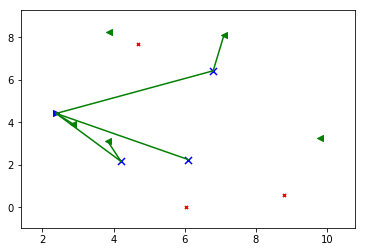

(762.6302361870196, 2, 20.0, 0.2340089078995329, 3)

In [3]:
# costs, nr_uncovered_DPs, total_uncovered_demand, total_distr_time, nr_op_fls = 
FL_model(
    100,
    1,
    True,
    FL_range=2,
    dist_method="euclidean",
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL)

# FL Model Nepal

## Nepal Data

In [2]:
Nepal = pd.read_excel("Data/Nepal Cities Population.xlsx", usecols=[1,2,3,4])

# Take only larger cities, because of many null values under 50000 inhabitants. 
# TODO find better dataset with population and coordinates
Nepal = Nepal [Nepal.Population >= 50000]
Nepal.head(1)

,City,Population,Latitude (DD),Longitude (DD)
0,Kathmandu,743300,27.71,85.31


In [3]:
airports = pd.read_excel("Data/Nepal Airports.xlsx", usecols=[0,5,6])
int_airports = airports[airports['Airport'] == "Tribhuvan intl"]
int_airports.head()

,Airport,Latitude (DD),Longitude (DD)
7,Tribhuvan intl,27.7,85.36


### Get Nepal Facility Location nodes - Unfinished: Do: GIS analysis

In [2]:
import osmnx as ox
# G = ox.graph_from_place('Amsterdam, The Netherlands',infrastructure='way["primary"]')
gdf = ox.pois_from_place(place='Kamppi, Helsinki, Finland')

Exception: Server returned no JSON data.
<Response [400]> Bad Request
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
<head>
  <meta http-equiv="content-type" content="text/html; charset=utf-8" lang="en"/>
  <title>OSM3S Response</title>
</head>
<body>

<p>The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.</p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: ';' expected - ')' found. </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: Unexpected end of input. </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: static error: Element "print" cannot be subelement of element "union". </p>

</body>
</html>


In [3]:
ox.__version__

'0.8dev'

In [4]:
boston_q = "Boston, Massachusetts, United States of America"
boston_poly = ox.gdf_from_place(boston_q, buffer_dist=2000)
universities = ox.pois_from_polygon(boston_poly.geometry.values[0], amenities=['university'])
list(universities.name.unique())

Exception: Server returned no JSON data.
<Response [400]> Bad Request
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
<head>
  <meta http-equiv="content-type" content="text/html; charset=utf-8" lang="en"/>
  <title>OSM3S Response</title>
</head>
<body>

<p>The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.</p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: ';' expected - ')' found. </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: Unexpected end of input. </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: static error: Element "print" cannot be subelement of element "union". </p>

</body>
</html>


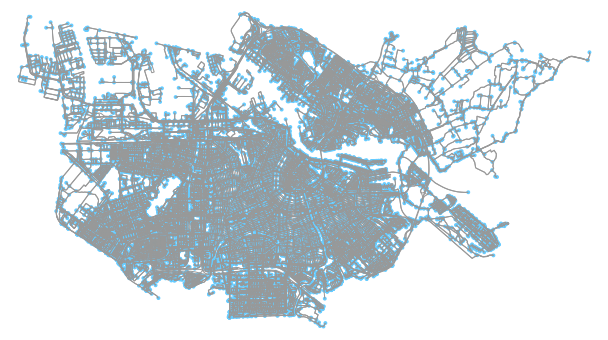

(<Figure size 1288.72x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1936d4c6c88>)

In [11]:
ox.plot_graph(G)

### random Data FLS, DPS

In [4]:
DPs = Nepal
np.random.seed(0)
DPs['Demand_estimate'] = np.random.randint(0, 100, DPs.shape[0]) * DPs['Population']  # change random for impact factor
DPs['Demand_lower'] = DPs['Demand_estimate'] * 0.9
DPs['Demand_upper'] = DPs['Demand_estimate'] * 1.1
DPs['Demand_actual'] = np.random.uniform(DPs['Demand_lower'],DPs['Demand_upper'])
DPs['Demand_actual'] = DPs['Demand_actual'].apply(int)
DPs.head()

,City,Population,Latitude (DD),Longitude (DD),Demand_estimate,Demand_lower,Demand_upper,Demand_actual
0,Kathmandu,743300,27.71,85.31,32705200,29434680.0,35975720.0,32574229
1,Biratnagar,178000,26.46,87.28,8366000,7529400.0,9202600.0,8186607
2,Lalitpur,172400,27.68,85.32,11033600,9930240.0,12136960.0,11775231
3,Pokhara,169700,28.22,83.99,11369900,10232910.0,12506890.0,11000142
4,Birganj,119500,27.02,84.87,8006500,7205850.0,8807150.0,8243767


In [5]:
SPs = int_airports.reset_index(drop=True)
SPs

,Airport,Latitude (DD),Longitude (DD)
0,Tribhuvan intl,27.7,85.36


In [8]:
long = np.random.uniform(DPs['Longitude (DD)'].min(),
                         DPs['Longitude (DD)'].max(), 20)
lat = np.random.uniform(DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max(),
                        20)
FLs = pd.DataFrame([lat, long], index=['Lat', 'Lon']).T
FLs['Name'] = ['FLO{}'.format(i) for i in range(FLs.shape[0])]
FLs = FLs[['Name', 'Lat', 'Lon']]
FLs.head()

,Name,Lat,Lon
0,FLO0,28.889863,82.715101
1,FLO1,28.655484,80.585501
2,FLO2,27.734061,85.012656
3,FLO3,26.599287,87.424993
4,FLO4,27.587898,85.150232


In [9]:
FLs.shape

(20, 3)

## Nepal Instantiation 

In [10]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(Nepal['Latitude (DD)'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(Nepal['Longitude (DD)'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(int_airports['Latitude (DD)'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(int_airports['Longitude (DD)'])}

# Create random facility locations
# lon lat min:

# long_min, lat_min, long_max, lat_max = 80, 25.767, 88.183, 30.45

# nr_of_FLs = 6
# FLX = {"FLX{}".format(i): random.uniform(long_min,long_max) for i in range(nr_of_FLs)}
# FLY = {"FLY{}".format(i): random.uniform(lat_min,lat_max) for i in range(nr_of_FLs)}
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# # Uncertainties + Ranges
# # For direct input model
# nr_of_SPs = 1
# nr_of_DPs = 5

# nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
# areasize = 10

# # Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(len(FLX))}

# Decision Variables
FLO = {key:0 for key in FLs.Name}

## Nepal Model Evaluator

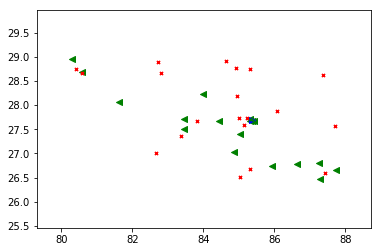

(844.0169777569713, 14, 140.0, 0.3729318150029861, 0)

In [119]:
FL_model(
    100,
    1,
    True,
    FL_range=10,
    dist_method="great_circle",
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL)

# Multi-Objective Optimisation Framework

Pseudocode:

    Current situation
    Create possible options (full factorial)
    Evaluate all possible options
    Check pareto front of outcomes

In [15]:
current_situation = FLO
current_situation

{'FLO0': 0,
 'FLO1': 0,
 'FLO2': 0,
 'FLO3': 0,
 'FLO4': 0,
 'FLO5': 0,
 'FLO6': 0,
 'FLO7': 0,
 'FLO8': 0,
 'FLO9': 0}

In [16]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    """
    # All FL names
    FL_keys = sorted(FL_dict.keys())
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]
    
    i_operational_fls = i_FL_op = [i for i,x in enumerate(FL_values) if x == 1]
    
    # Create list of policies  
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:,i_operational_fls] = 1
    
    #Delete policies where no new FLs are placed 
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis = 1) == new_n_operational_fls]

    
    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key:value for key,value in zip(FL_keys,pol)})
    
    if print_pols == True:
        print("total policies:",len(policy_list))
        for n,i in enumerate(policy_list):
            for v in i.values():
                print (int(v), end='')
            print(" <- policy {}".format(n))
                
    return policy_list

In [17]:
policies = create_policies(current_situation, print_pols=True)

total policies: 10
1000000000 <- policy 0
0100000000 <- policy 1
0010000000 <- policy 2
0001000000 <- policy 3
0000100000 <- policy 4
0000010000 <- policy 5
0000001000 <- policy 6
0000000100 <- policy 7
0000000010 <- policy 8
0000000001 <- policy 9


In [18]:
outcomes = []
for policy in policies:
    outcomes.append(FL_model(
    100,
    1,
    graphical_representation = False,
    dist_method="great_circle",
    FL_range=50,
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **policy,
    **DSRDP,
    **DSRFL))

In [19]:
outcomes

[(20850.291021190973, 11, 110.0, 4.328472433042579, 1.0),
 (26566.73797838991, 12, 120.0, 7.189166820116344, 1.0),
 (9483.899685448469, 13, 130.0, 3.0318785279050364, 1.0),
 (21412.996467635672, 13, 130.0, 7.008244121967434, 1.0),
 (24396.09386201193, 13, 130.0, 8.002609920092855, 1.0),
 (16691.357427998726, 13, 130.0, 5.434364442088452, 1.0),
 (23501.796620111334, 13, 130.0, 7.704510839459321, 1.0),
 (20392.17186596251, 13, 130.0, 6.667969254743046, 1.0),
 (14789.558167291449, 13, 130.0, 4.800431355186027, 1.0),
 (11722.06574784349, 13, 130.0, 3.777933882036706, 1.0)]

In [20]:
# Non-dominated sorting for outcomes
outcomes_df = pd.DataFrame(outcomes)

# options for pareto sorting
# minimising is default
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

nondominated = pareto.eps_sort([list(outcomes_df.itertuples(True))],[1,2,3,4,5], [1e-9,1e-9,1e-9,1e-9,1e-9])
nondominated

[[0, 20850.291021190973, 11, 110.0, 4.328472433042579, 1.0],
 [2, 9483.899685448469, 13, 130.0, 3.0318785279050364, 1.0]]

In [21]:
# policies for all nondominated policies
i = [a[0] for a in nondominated]
policies = np.array(policies)
policies[i]

array([{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 1.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0}],
      dtype=object)

# EMA Framework

In [24]:
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## EMA instantiations

In [25]:
models = []
t = 0
model = Model("flmodelt{}".format(t), FL_model)


model.locations = [
    Constant("DPX{}".format(i), x)
    for i, x in zip(DPs.index, DPs['Longitude (DD)'])
] + [
    Constant("DPY{}".format(i), y)
    for i, y in zip(DPs.index, DPs['Latitude (DD)'])
] + [
    Constant("SPX{}".format(i), x) for i,x in zip(SPs.index, SPs['Longitude (DD)'])
] + [
    Constant("SPY{}".format(i), y) for i,y in zip(SPs.index, SPs['Latitude (DD)'])
] + [
    Constant("FLX{}".format(i), x) for i,x in zip(FLs.index, FLs['Lon'])
] + [
    Constant("FLY{}".format(i), y) for i,y in zip(FLs.index, FLs['Lat'])
]


# model.locations_uncertain =   [
#     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
# ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]




model.constants = [
    Constant('graphical_representation', True),
    Constant('dist_method', 'great_circle'),
    Constant('Error_Test', 1), # this doesn't do anything. 
    #list of other constants
    #     Constant
] + model.locations



# Reachability of Demand Points and Facility Locations can be disrupted
model.disruptions = [
    RealParameter("DSRFL{}".format(i), -0.5, 0.5) for i in range(FLs.shape[0])
] + [RealParameter("DSRDP{}".format(i), -0.5, 0.5) for i in range(DPs.shape[0])]

model.uncertainties = [
    RealParameter('unit_opening_costs', 100, 200),
    RealParameter('unit_transport_cost', 0.5,
                  2),  # cost of transporting one unit of relief goods
    RealParameter('FL_range', 100, 300),  # km TODO: great circle distance
    RealParameter(
        'lorry_speed', 30, 60
    ),  # km/h. Speed is Average speed. Constant, because roads are individually disrupted 
    #list of other uncertainties
] + model.disruptions #+ model.locations_uncertain

models.append(model)

In [26]:
for model in models:
    print(model.name)

flmodelt0


In [27]:
test_pol = policies[i][0]
Policy("test_pol",**test_pol)

{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0}

[MainProcess/INFO] performing 4 scenarios * 1 policies * 1 model(s) = 4 experiments
[MainProcess/INFO] performing experiments sequentially


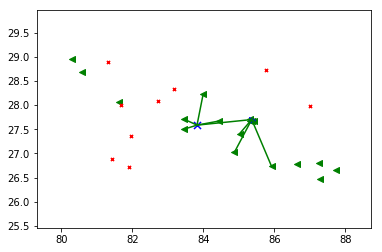

[MainProcess/INFO] 1 cases completed


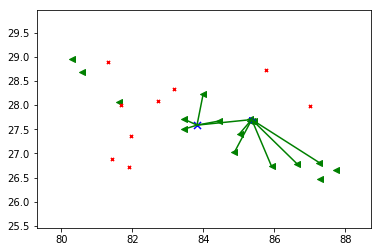

[MainProcess/INFO] 2 cases completed


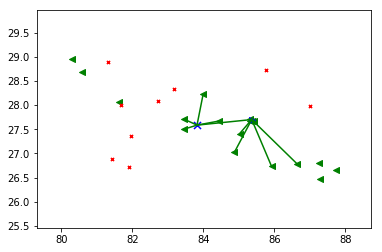

[MainProcess/INFO] 3 cases completed


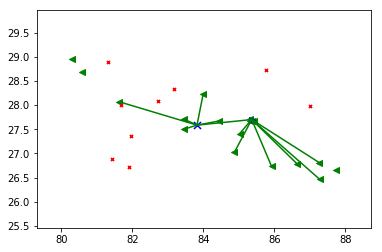

[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] experiments finished


(array([( 0.10965038, -0.10453742, -0.3359176 ,  0.40571152,  0.40121138, -0.42050421,  0.12724224,  0.46058552, -0.49497311, -0.17788089, -0.19422959,  0.45344945, -0.35288373, -0.0984017 ,  0.18729246, -0.35641869, -0.14103377, -0.07143968, -0.30523725, -0.32564281,  0.05768558, -0.2364155 , -0.26397006,  0.14430715, -0.06228894, -0.2639069 , -0.12804057,  0.01681241, 123.47485915, 47.40012863, 157.79650552, 1.33081538, 0, 'test_pol', 'flmodelt0'),
        ( 0.49709346,  0.10359215,  0.03454574, -0.33158509, -0.31518411, -0.14643425, -0.02081926, -0.08820646, -0.04276499, -0.39167798, -0.26181275,  0.09912644,  0.4149171 ,  0.0047983 , -0.03038695,  0.1633002 , -0.27701916,  0.24971175,  0.46623332,  0.11338567, -0.30877208, -0.45000087,  0.40206322, -0.19052679, -0.25887756,  0.4348877 , -0.27974886, -0.33015181, 222.80073116, 40.37597921, 135.63628845, 1.23026397, 1, 'test_pol', 'flmodelt0'),
        (-0.2244888 , -0.38132562, -0.20085441,  0.24298625, -0.24020305,  0.26603687, -0.

In [28]:
perform_experiments(model,4,Policy("test_pol",**test_pol))

# Robustness Framework

# Next iteration Framework